# `photoeccentric` sensitivitiy tests

This notebook sets up a sensitivity test for `photoeccentric` to determine how accurately it recovers eccentricity with simulated transits. In general, this is also how I would structure the code to recover eccentricities for a large number of planets in sequence.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I'll fit the transits with `emcee`, which takes a number of walkers, steps, and steps to discard. I'm defining them here so I can create my planet parameter distributions (period, rp/rs, a/rs, inclination) to be the proper length.

In [54]:
nwalk = 64
nsteps_d = 3000
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [55]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

To run with Kepler light curves, determine the stellar mass and radius from any sources. Here I'm compiling a table of the stellar parameters from the NASA exoplanet archive, adding the stellar data from spectroscopy (Muirhead et al. 2013) and luminosities from Gaia, and using ph.fit_isochrone_lum() to fit stellar isochrones to these data. The mass, mass error, radius, and radius error of the fit isochrones will produce my mass + radius distributions which I will use to determine the stellar density distribution.

In [56]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

## Outline for Sensitivity Test

1. Define "test planet" parameters. These parameters will come from a real Kepler planet, but I'll use a fake light curve. These "test planet" parameters will stay the same across the entire test.
2. Write two functions: one that wraps the entire light curve initialization process, and one that wraps the transit fit and eccentricity estimation.
3. For each eccentricity recovered, take the difference between the input e and the peak of the e distribution as the error.
4. Plot on a heatmap

#### Defining a "test planet"

In [59]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

In [60]:
# ph.fit_isochrone_lum() steps through all MESA isochrones and matches the ones that fit the given parameters
iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from crashing)
iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

100%|██████████| 738479/738479 [01:09<00:00, 10669.95it/s]


In [62]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [63]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

Text(0.5, 1.0, 'Stellar Density (KIC 5868793) [kg m^-3]')

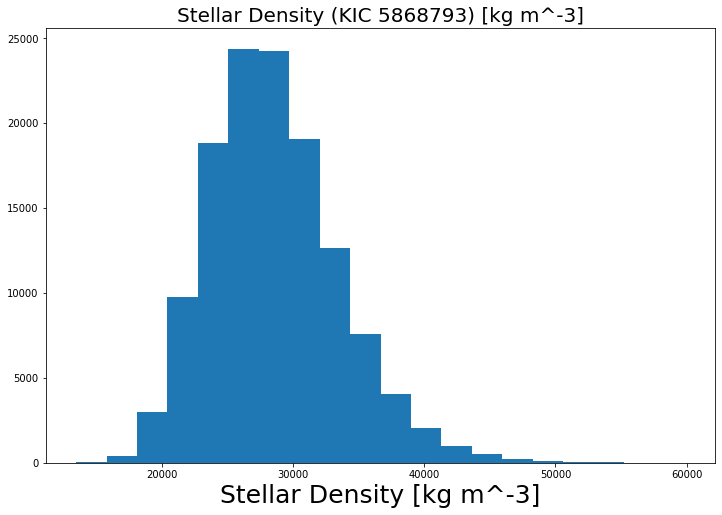

In [65]:
plt.hist(rho_star, bins=20)
plt.xlabel("Stellar Density [kg m^-3]", fontsize=25)
plt.title("Stellar Density (KIC 5868793) [kg m^-3]", fontsize=20)

In [66]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


##### Calculate A_rs prior:

In [67]:
pdist = np.random.normal(period, np.mean((abs(period_uerr), abs(period_lerr))), len(rhos_gaia))

a_rs_gaia = ph.get_a_rs(rhos_gaia, pdist)
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)

a_rs_guess = np.mean(a_rs_gaia)

#a/Rs priors to put in transit fitting
a_rs_priors = [a_rs_guess-10*np.std(a_rs_gaia), a_rs_guess+10*np.std(a_rs_gaia)]

# Using photo_init and photo_fit

In [73]:
# e and w drawn randomly from unifrom distribution

n = 10

e_rand = np.random.uniform(0.0, 1.0, size=n)
w_rand = np.random.uniform(-90.0, 90.0, size=n)

In [74]:
# initialize arrays w zeros

gmeans = np.zeros(n)
gsigs = np.zeros(n)
es_best = np.zeros(n)
ws_best = np.zeros(n)
zscores = np.zeros((n, 2))

This cell measures (e,w) for n synthetic transits. All transits assume the exact same system (both stellar and planet parameters), except for e and w. Here I am simulating Kepler-1582b over and over with different (e,w) each time, and seeing if photoeccentric recovers the correct values.

`zscores` is a list of length 2. Index 0 is the zscore of the fit eccentricity compared to the true eccentricity. Index 1 is the zscore of the fit w compared to the true w. This isn't a good way to do this but ehhh idk yet

`direct` needs to be set as the directory where you want plots to be saved

In [ ]:
print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(n):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    
    dr = 'e_' + str(e_rand[j]) + '_w_' + str(w_rand[j])
    direct = 'plots/' + dr + '/'
    
    if not os.path.exists(direct):
        os.mkdir(direct)
    
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = ph.photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])

    # nsteps kept 1000, nwalkers 32, len(result) 32000
    
    guess_transit = np.array([ph.bls(ttime, tflux), 0.036066, a_rs_guess, 89.9, 90.0])
    guess_ew = np.array([0, 0])
    
    beste, bestw, edist, wdist, gs, g_mean, g_sigmas, zsc = ph.photo_fit(ttime, tflux, tflux_err, guess_transit, guess_ew, rho_star, e_rand[j], w_rand[j], direct, nwalk, nsteps_d, ndiscard_d) 
    gmeans[j] = g_mean
    gsigs[j] = np.mean(g_sigmas)
    es_best[j] = beste
    ws_best[j] = bestw
    zscores[j] = np.mean(zsc)
    print("Best e: ", beste)


Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.5708796080115855 w:  77.37120578177183


100%|██████████| 3000/3000 [07:04<00:00,  7.07it/s]


Fit params:
Period (days):  4.840951402255916
Rp/Rs:  0.03533368452822771
a/Rs:  59.39108599825722
i (deg):  89.81583175847375


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 66/5000 [00:00<00:07, 657.81it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 701.24it/s]


Best e:  0.6182639104701073
e:  0.06946763651103549 w:  -75.06771604488014


 42%|████▏     | 1258/3000 [03:06<07:20,  3.96it/s]

In [ ]:
es_best = np.array(es_best)
ws_best = np.array(ws_best)
zscores = np.array(zscores)

np.savetxt('plots/results/32421_e_best.csv', es_best, delimiter=',')
np.savetxt('plots/results/32421_w_best.csv', ws_best, delimiter=',')
np.savetxt('plots/results/32421_e_rand.csv', e_rand, delimiter=',')
np.savetxt('plots/results/32421_w_rand.csv', w_rand, delimiter=',')
np.savetxt('plots/results/32421_zscores_e.csv', abs(zscores[:,0]), delimiter=',')
np.savetxt('plots/results/32421_zscores_w.csv', abs(zscores[:,1]), delimiter=',')

In [ ]:
plt.scatter(e_rand, w_rand, c=zscores[:,0])
plt.xlim(0.0, 1.0)
plt.ylim(-90., 90.)
plt.xlabel('True e')
plt.ylabel('True w')
plt.colorbar()

Color corresponds to e error